In [ ]:
!python -m spacy download en_core_web_lg

In [140]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel


from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [114]:
data = pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')
data = data[['airline_sentiment', 'text']]
print(data.shape, data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 228.9+ KB
(14640, 2) None


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<BarContainer object of 3 artists>

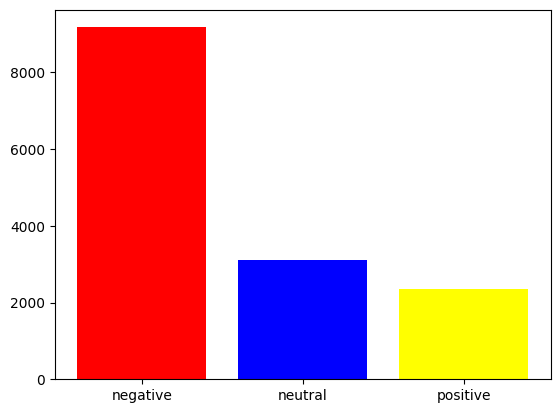

In [115]:
target_cnt = data['airline_sentiment'].value_counts()
plt.bar(target_cnt.index, target_cnt, color = ['red', 'blue', 'yellow'])

In [116]:
min_class_count = data['airline_sentiment'].value_counts().min()

balanced_data = pd.concat([
    data[data['airline_sentiment'] == 'positive'].sample(min_class_count, random_state=42),
    data[data['airline_sentiment'] == 'neutral'].sample(min_class_count, random_state=42),
    data[data['airline_sentiment'] == 'negative'].sample(min_class_count, random_state=42)
])

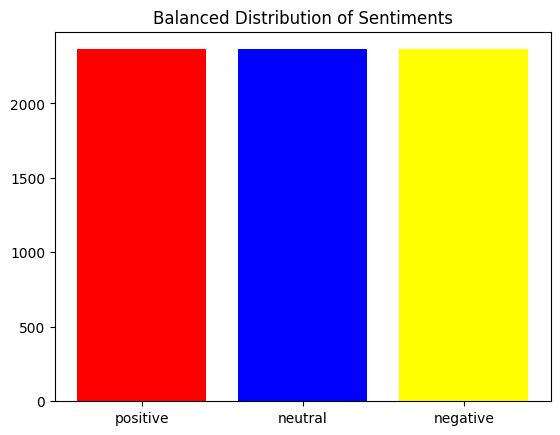

In [117]:
target_cnt_balanced = balanced_data['airline_sentiment'].value_counts()
plt.bar(target_cnt_balanced.index, target_cnt_balanced, color=['red', 'blue', 'yellow'])
plt.title('Balanced Distribution of Sentiments')
plt.show()

In [145]:
def prepro(text):
    _text = text.lower()
    _text = re.sub(r'@\w+', '@user', _text)
    _text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', _text)
    _text = re.sub(r'[^a-z\s]', ' ', _text)
    return _text #, doc.ents 

def conv(x):
    if x == 'positive': return 2
    elif x == 'neutral': return 1
    elif x == 'negative': return 0

In [146]:
prepro('hey@AmericanAir Please bring american airlines to #BlackBerry10')

'hey user please bring american airlines to  blackberry  '

In [147]:
data['text'].isna().any(), data['airline_sentiment'].isna().any()

(False, False)

In [148]:
x = data['text'].apply(prepro).to_list()
y = data['airline_sentiment'].apply(conv).to_list()

In [149]:
x_train, x_test, y_train, y_test = tts(x, y, test_size = .2, random_state = 42, stratify = y)

In [150]:
class BertEmbeddingDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.labels = torch.tensor(labels, dtype=torch.long) # convert labels to tensor
        
        print("Computing BERT embeddings...")
        model = BertModel.from_pretrained('bert-base-uncased') # from HF
        model.eval() # to disable dropout & batch norm
        
        self.embeddings = []
        
        with torch.no_grad(): # no_grad (so no memory is kept)
            for i, text in enumerate(texts):
                if i % 100 == 0:
                    print(f"Processing text {i}/{len(texts)}")
                    
                encoding = tokenizer(text, 
                                   truncation=True,
                                   padding='max_length',
                                   max_length=max_length,
                                   return_tensors='pt')
                
                outputs = model(**encoding) # ** to unpack dict values
                embedding = outputs.last_hidden_state[:, 0, :].squeeze(0) # uses the [CLS] token embedding
                self.embeddings.append(embedding)
        
        self.embeddings = torch.stack(self.embeddings)
        print("Embeddings computed!")

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'embeddings': self.embeddings[idx],
            'labels': self.labels[idx]
        }


class BertFineTuneDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', 
                                 max_length=max_length, return_tensors='pt')
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

In [196]:
class PurePyTorchClassifier(nn.Module):
    # input _dim is set to 768 because that's BERT's embed size
    def __init__(self, input_dim=768, hidden_dims=[512, 256], output_dim=3):
        super(PurePyTorchClassifier, self).__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims: # first layer has 512, second one has 256
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, output_dim)) # 3 output
        
        self.network = nn.Sequential(*layers) # join 'em up
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.network(x)

    def compute_loss(self, outputs, labels):
        return self.criterion(outputs, labels)

# BERT Fine-tuning model
class BertClassifier(nn.Module):
    def __init__(self, output_dim=3):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(768, output_dim)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask) 
        '''
        BERT accepts 2 inputs, the input_ids and attention mask
        input_ids such as [121, 122, 199, 200, 999, 102]
        attention_mask such as [1, 1, 0, 0, 1, 1]
        '''
        pooled_output = outputs.pooler_output # extracts the representation of [CLS] token
        x = self.dropout(pooled_output)
        return self.fc(x) # final pred

    def compute_loss(self, outputs, labels):
        return self.criterion(outputs, labels)

In [152]:
def train_pytorch_epoch(model, train_loader, optimizer, device):
    model.train() # starts training mode
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, batch in enumerate(train_loader):
        embeddings = batch['embeddings'].to(device) # take embed for that batch
        labels = batch['labels'].to(device) # take labels for that batch
        
        # resets the gradient to prevent accumulation from previous steps
        optimizer.zero_grad() 
        outputs = model(embeddings)
        loss = model.compute_loss(outputs, labels)
        
        # takes highest logit
        # outputs are {logits, label} and we only need the label
        _, predicted = torch.max(outputs.data, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        loss.backward()
        optimizer.step() # update weights here
        
        total_loss += loss.item()
        
        if batch_idx % 50 == 0:
            accuracy = 100. * correct / total
            print(f'Batch {batch_idx}/{len(train_loader)} | '
                  f'Loss: {loss.item():.4f} | Acc: {accuracy:.2f}%')
    
    return total_loss / len(train_loader), 100. * correct / total

def train_bert_epoch(model, train_loader, optimizer, device):
    model.train() # start training mode
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}

        optimizer.zero_grad()
        outputs = model(batch['input_ids'], batch['attention_mask'])
        loss = model.compute_loss(outputs, batch['labels'])
        
        _, predicted = torch.max(outputs.data, 1)
        total += batch['labels'].size(0)
        correct += (predicted == batch['labels']).sum().item()
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 50 == 0:
            accuracy = 100. * correct / total
            print(f'Batch {batch_idx}/{len(train_loader)} | '
                  f'Loss: {loss.item():.4f} | Acc: {accuracy:.2f}%')
    
    return total_loss / len(train_loader), 100. * correct / total

In [154]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print("Creating PyTorch dataset...")
pytorch_train_dataset = BertEmbeddingDataset(x_train, y_train, tokenizer)
pytorch_test_dataset = BertEmbeddingDataset(x_test, y_test, tokenizer)

print("Creating BERT dataset...")
bert_train_dataset = BertFineTuneDataset(x_train, y_train, tokenizer)
bert_test_dataset = BertFineTuneDataset(x_test, y_test, tokenizer)

Using device: cuda
Creating PyTorch dataset...
Computing BERT embeddings...
Processing text 0/11712
Processing text 100/11712
Processing text 200/11712
Processing text 300/11712
Processing text 400/11712
Processing text 500/11712
Processing text 600/11712
Processing text 700/11712
Processing text 800/11712
Processing text 900/11712
Processing text 1000/11712
Processing text 1100/11712
Processing text 1200/11712
Processing text 1300/11712
Processing text 1400/11712
Processing text 1500/11712
Processing text 1600/11712
Processing text 1700/11712
Processing text 1800/11712
Processing text 1900/11712
Processing text 2000/11712
Processing text 2100/11712
Processing text 2200/11712
Processing text 2300/11712
Processing text 2400/11712
Processing text 2500/11712
Processing text 2600/11712
Processing text 2700/11712
Processing text 2800/11712
Processing text 2900/11712
Processing text 3000/11712
Processing text 3100/11712
Processing text 3200/11712
Processing text 3300/11712
Processing text 34

In [201]:
pytorch_train_loader = DataLoader(pytorch_train_dataset, batch_size=32, shuffle=True)
pytorch_test_loader = DataLoader(pytorch_test_dataset, batch_size=32, shuffle=False)
bert_train_loader = DataLoader(bert_train_dataset, batch_size=32, shuffle=True)
bert_test_loader = DataLoader(bert_test_dataset, batch_size=32, shuffle=False)

In [202]:
pytorch_model = PurePyTorchClassifier().to(device)
bert_model = BertClassifier().to(device)

pytorch_optimizer = torch.optim.AdamW(pytorch_model.parameters(), lr=1e-3, weight_decay=0.01)
bert_optimizer = torch.optim.AdamW(bert_model.parameters(), lr=2e-5, weight_decay=0.01)

In [203]:
epochs = 3

In [204]:
pytorch_losses, pytorch_accuracies = [], []
bert_losses, bert_accuracies = [], []

In [205]:
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    loss, acc = train_pytorch_epoch(pytorch_model, pytorch_train_loader, pytorch_optimizer, device)
    pytorch_losses.append(loss)
    pytorch_accuracies.append(acc)
    print(f"Epoch {epoch+1} - Loss: {loss:.4f}, Accuracy: {acc:.2f}%")


Epoch 1/3
Batch 0/366 | Loss: 1.1577 | Acc: 40.62%
Batch 50/366 | Loss: 0.5988 | Acc: 74.88%
Batch 100/366 | Loss: 0.6834 | Acc: 74.94%
Batch 150/366 | Loss: 0.6041 | Acc: 75.17%
Batch 200/366 | Loss: 0.6334 | Acc: 75.86%
Batch 250/366 | Loss: 0.7457 | Acc: 76.32%
Batch 300/366 | Loss: 0.5333 | Acc: 76.36%
Batch 350/366 | Loss: 0.5667 | Acc: 76.67%
Epoch 1 - Loss: 0.5764, Accuracy: 76.61%

Epoch 2/3
Batch 0/366 | Loss: 0.3550 | Acc: 87.50%
Batch 50/366 | Loss: 0.7713 | Acc: 81.19%
Batch 100/366 | Loss: 0.5147 | Acc: 80.85%
Batch 150/366 | Loss: 0.5900 | Acc: 80.34%
Batch 200/366 | Loss: 0.6253 | Acc: 80.07%
Batch 250/366 | Loss: 0.4950 | Acc: 79.89%
Batch 300/366 | Loss: 0.4546 | Acc: 79.78%
Batch 350/366 | Loss: 0.6961 | Acc: 79.54%
Epoch 2 - Loss: 0.5053, Accuracy: 79.59%

Epoch 3/3
Batch 0/366 | Loss: 0.3752 | Acc: 84.38%
Batch 50/366 | Loss: 0.7693 | Acc: 81.19%
Batch 100/366 | Loss: 0.2953 | Acc: 81.03%
Batch 150/366 | Loss: 0.3654 | Acc: 80.61%
Batch 200/366 | Loss: 0.3003 | Acc

In [206]:
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    loss, acc = train_bert_epoch(bert_model, bert_train_loader, bert_optimizer, device)
    bert_losses.append(loss)
    bert_accuracies.append(acc)
    print(f"Epoch {epoch+1} - Loss: {loss:.4f}, Accuracy: {acc:.2f}%")


Epoch 1/3
Batch 0/366 | Loss: 1.0858 | Acc: 34.38%
Batch 50/366 | Loss: 0.7589 | Acc: 63.85%
Batch 100/366 | Loss: 0.4764 | Acc: 71.29%
Batch 150/366 | Loss: 0.4274 | Acc: 74.03%
Batch 200/366 | Loss: 0.5326 | Acc: 76.10%
Batch 250/366 | Loss: 0.5029 | Acc: 76.98%
Batch 300/366 | Loss: 0.3187 | Acc: 77.84%
Batch 350/366 | Loss: 0.5330 | Acc: 78.53%
Epoch 1 - Loss: 0.5311, Accuracy: 78.80%

Epoch 2/3
Batch 0/366 | Loss: 0.2097 | Acc: 96.88%
Batch 50/366 | Loss: 0.3079 | Acc: 89.52%
Batch 100/366 | Loss: 0.3048 | Acc: 88.99%
Batch 150/366 | Loss: 0.2202 | Acc: 88.47%
Batch 200/366 | Loss: 0.2460 | Acc: 88.17%
Batch 250/366 | Loss: 0.1699 | Acc: 88.16%
Batch 300/366 | Loss: 0.3853 | Acc: 87.89%
Batch 350/366 | Loss: 0.2598 | Acc: 87.80%
Epoch 2 - Loss: 0.3306, Accuracy: 87.83%

Epoch 3/3
Batch 0/366 | Loss: 0.2168 | Acc: 90.62%
Batch 50/366 | Loss: 0.0927 | Acc: 93.08%
Batch 100/366 | Loss: 0.0863 | Acc: 92.73%
Batch 150/366 | Loss: 0.2000 | Acc: 93.09%
Batch 200/366 | Loss: 0.1763 | Acc

In [208]:
pytorch_model.eval()
pytorch_preds = []
pytorch_labels = []
with torch.no_grad():
    for batch in pytorch_test_loader:
        embeddings = batch['embeddings'].to(device)
        labels = batch['labels'].to(device)

        outputs = pytorch_model(embeddings)
        _, preds = torch.max(outputs, 1)
        
        pytorch_preds.extend(preds.cpu().numpy())
        pytorch_labels.extend(labels.cpu().numpy())

# Calculate accuracy
pytorch_test_accuracy = accuracy_score(pytorch_labels, pytorch_preds)
print(f"PyTorch Model Test Accuracy: {pytorch_test_accuracy * 100:.2f}%")

PyTorch Model Test Accuracy: 80.26%


In [209]:
bert_model.eval()
bert_preds = []
bert_labels = []

with torch.no_grad():
    for batch in bert_test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        logits = bert_model(input_ids, attention_mask=attention_mask)
        
        _, preds = torch.max(logits, 1)

        bert_preds.extend(preds.cpu().numpy())
        bert_labels.extend(labels.cpu().numpy())

bert_test_accuracy = accuracy_score(bert_labels, bert_preds)
print(f"BERT Model Test Accuracy: {bert_test_accuracy * 100:.2f}%")

BERT Model Test Accuracy: 83.67%


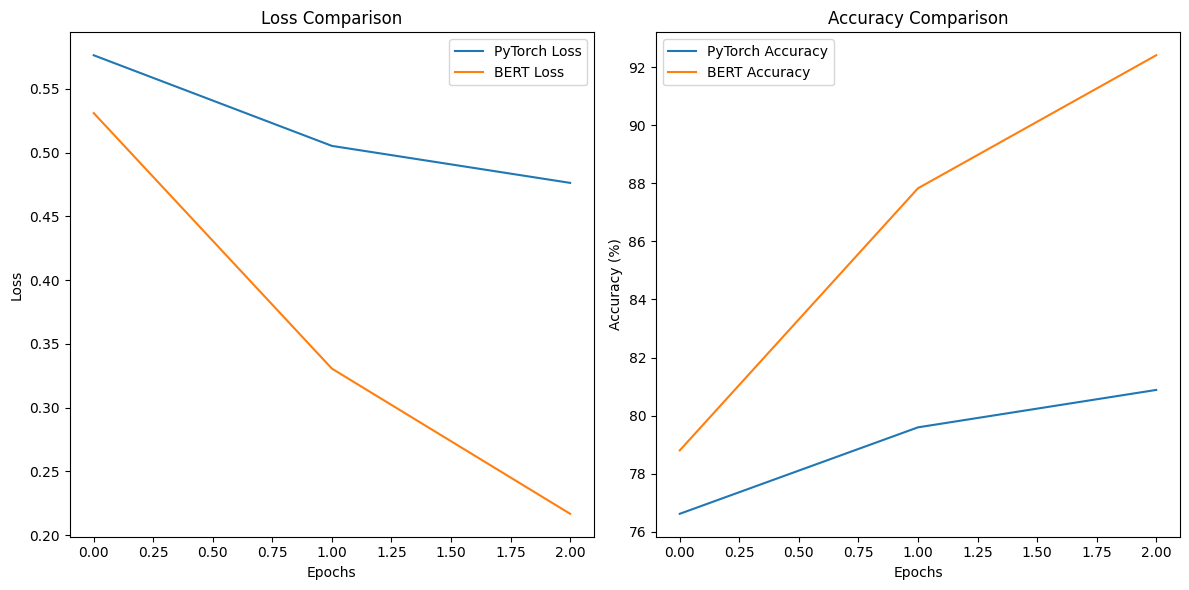

In [207]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(pytorch_losses, label='PyTorch Loss')
plt.plot(bert_losses, label='BERT Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(pytorch_accuracies, label='PyTorch Accuracy')
plt.plot(bert_accuracies, label='BERT Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.show()